The goal here is to check shape outputs from the version of the code in this repo vs. that from [Hongyu's](https://github.com/HongyuLi2016/illustris-tools ) from which we have an output for Illustris-1.

We downloaded the Illustris cutouts by runnig `get_illustris_data.py` and then calculated the shape using `bash_get_illustris_shapes.sh`; both scipts are in the `runscript` folder in the main repo.

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
%matplotlib inline

In [2]:
# plot style
from d3g2d import rcparams
import matplotlib.ticker as mtick
for key in rcparams: mpl.rcParams[key] = rcparams[key]

Now read in the shape data using `d2g2d` as well as that from Hongyu's original code. Compare 1-1 for some haloes first.

Considering halo 321637
../data/illustris_mass_shape/shape-all-11p0/shape_subhalo321637.dat
Reading shape_105Rvals.dat from ../outputs/test_illustris//Illustris-1_halo321637_z0.0


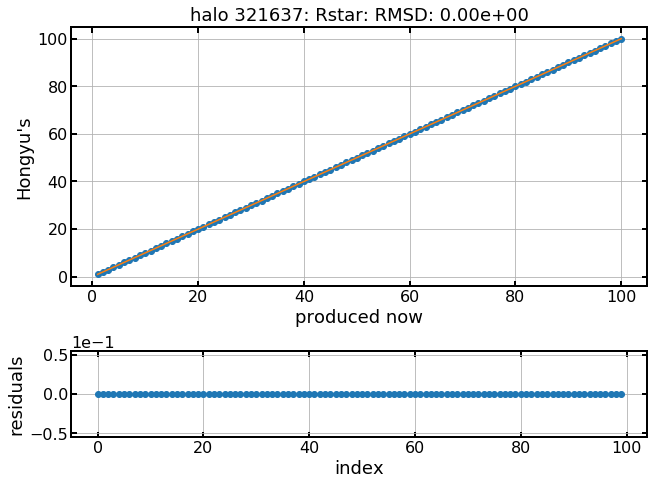

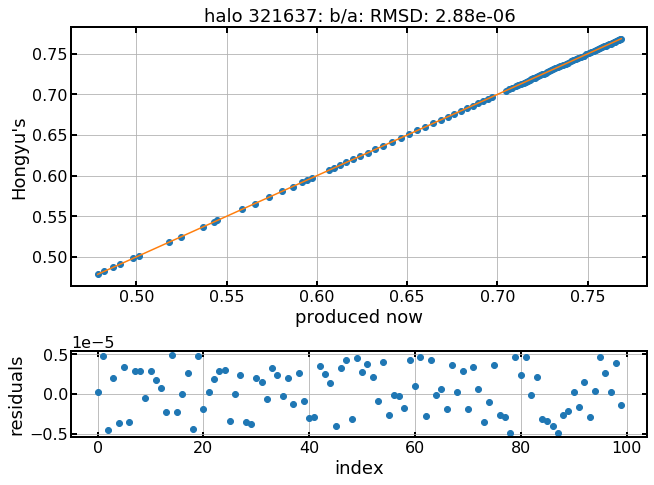

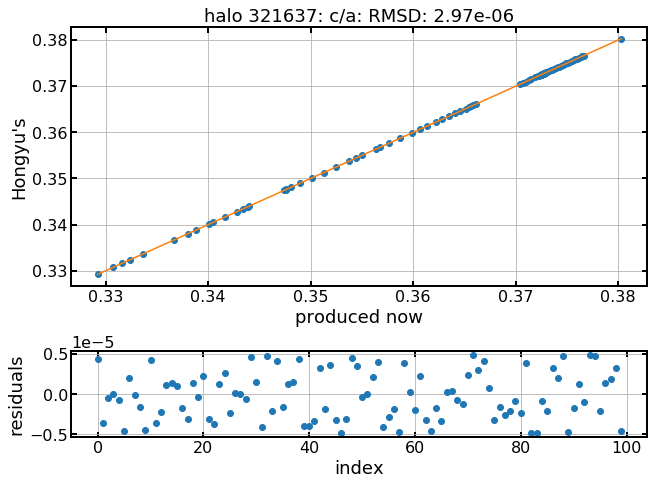

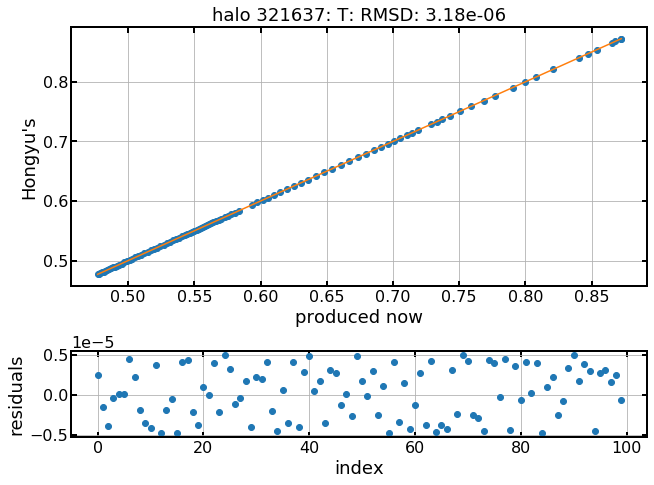

Considering halo 16946
../data/illustris_mass_shape/shape-all-11p0/shape_subhalo16946.dat
Reading shape_105Rvals.dat from ../outputs/test_illustris//Illustris-1_halo16946_z0.0


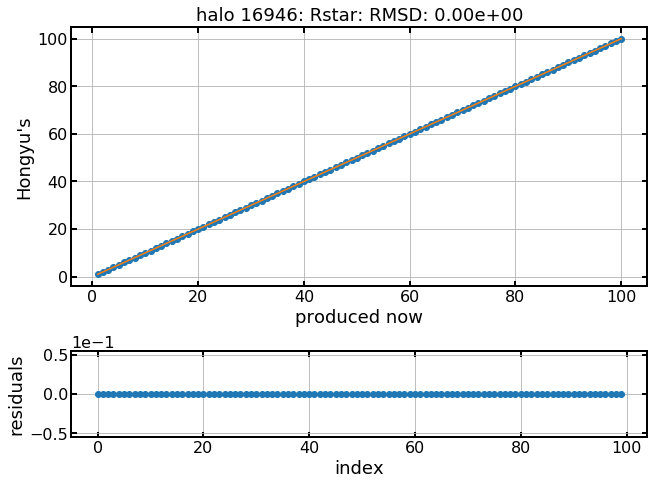

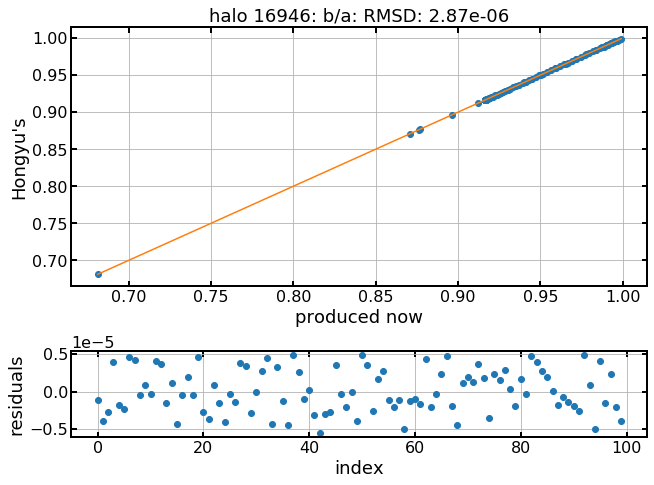

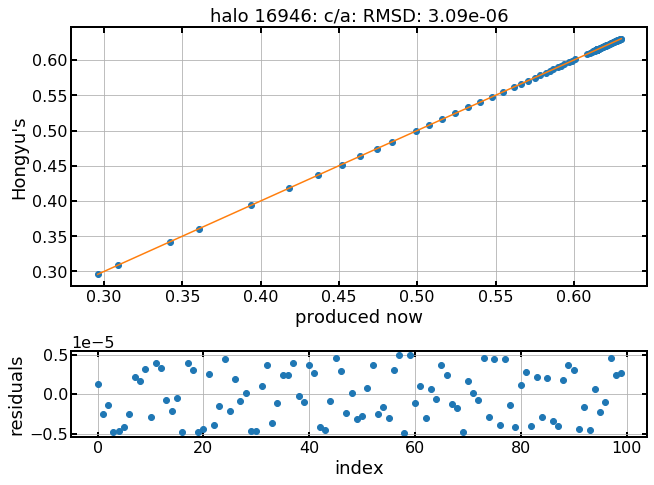

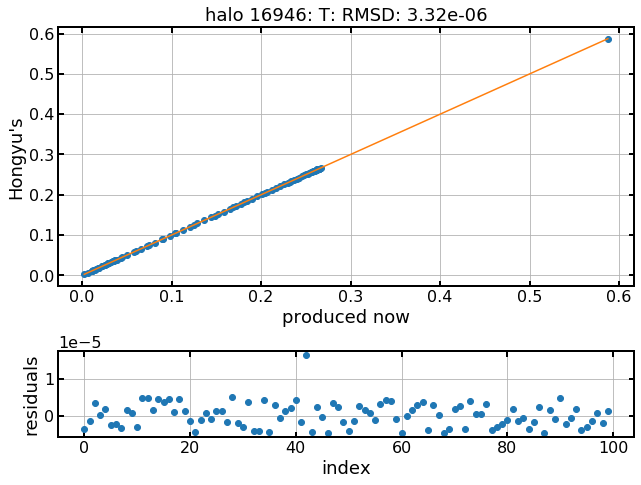

In [3]:
data_dir = '../outputs/test_illustris/'
shape_tag = 'shape_105R'

# loop over the local foders; each folder is for a specific halo
for folder in [f for f in os.listdir(data_dir) if f.startswith('Illustris')][0:2]:
    haloId = int( folder.split('halo')[-1].split('_')[0] )
    print('Considering halo %s' % haloId)
    # ---------------------------------------------------------------------
    # first read in the data from Hongyu's catalog
    print('../data/illustris_mass_shape/shape-all-11p0/shape_subhalo%s.dat' % haloId )
    data_orig = np.loadtxt( '../data/illustris_mass_shape/shape-all-11p0/shape_subhalo%s.dat' % haloId )
    # set up the dictionary
    data_orig = {'Rstar': data_orig[:, 0],
                 'b/a': data_orig[:, 1],
                 'c/a': data_orig[:, 2],
                 'T': data_orig[:, 3]
                }
    # ---------------------------------------------------------------------
    # now read in the data produced from my version
    file = [ f for f in os.listdir('%s/%s' % (data_dir, folder)) if f.startswith(shape_tag)][0]

    print('Reading %s from %s/%s' % (file,data_dir, folder))
    with open('%s/%s/%s' % (data_dir, folder, file), 'rb') as f:
        data_now = pickle.load(f)
    # add triaxility param
    data_now['T'] = (1 -  data_now['b/a'] ** 2 ) / (1 -  data_now['c/a'] ** 2 )        
    # ---------------------------------------------------------------------
    # plot the data + residuals 
    # note: the shape data was calculated for more than just 1-100kpc.
    # Since the match catalog  has data for just 1-100kpc, we access the first 100 entries
    # for comparison
    
    for key in data_now:
        min_val = min([min(data_now[key][0:100]), min(data_orig[key])])
        max_val = max([max(data_now[key][0:100]), max(data_orig[key])])

        fig = plt.figure()
        # plot the data
        f1 = fig.add_axes((.1,.3,.8,.6))
        plt.plot(data_now[key][0:100], data_orig[key], 'o')
        plt.plot([min_val, max_val], [min_val, max_val], '-')
        rmsd = np.sqrt(np.sum((data_orig[key]-data_now[key][0:100])**2)/len(data_orig[key]))
        plt.title('halo %s: %s: RMSD: %.2e'% (haloId, key, rmsd) )
        plt.ylabel("Hongyu's")
        plt.xlabel('produced now')
        # now plot the residuals
        f2 = fig.add_axes((.1,-0.05,.8,.2))        
        plt.plot(data_now[key][0:100] - data_orig[key], 'o')
        plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        plt.ylabel('residuals')
        plt.xlabel('index')

        plt.show()


Okay things look reasonable. Now check the residuals for all haloes.

<Figure size 720x432 with 0 Axes>

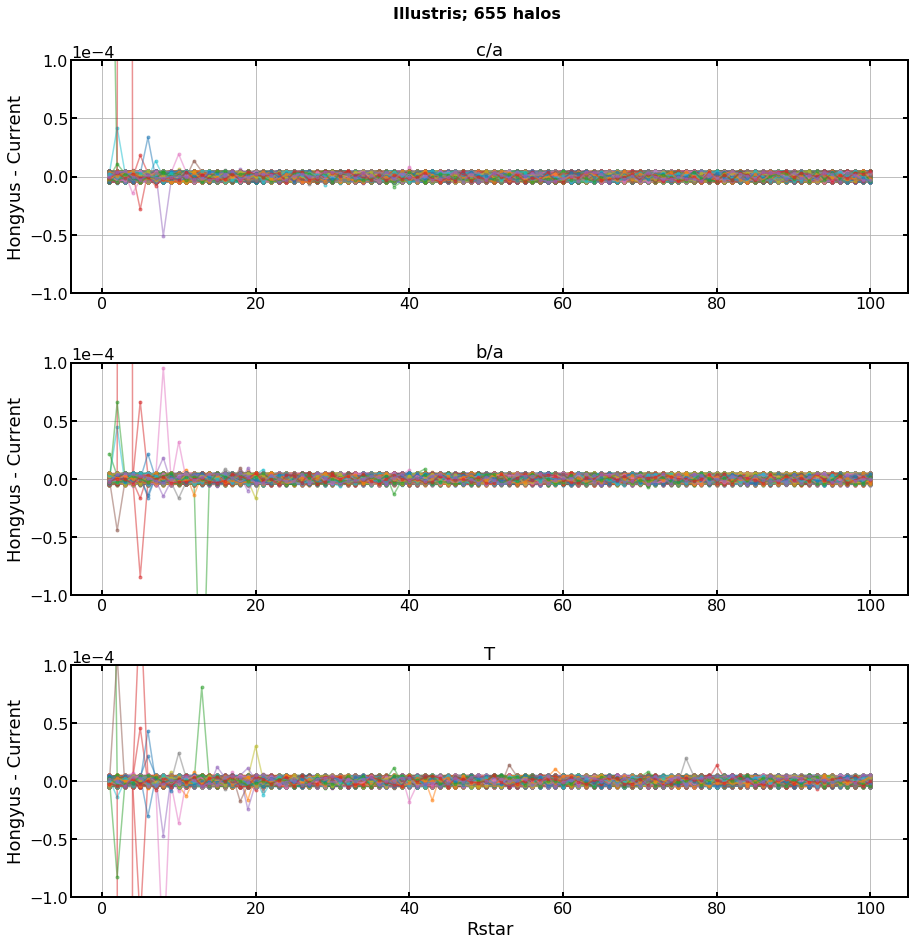

In [4]:
plt.clf()
nrows, ncols = 3, 1
fig, axes = plt.subplots(nrows, ncols)
plt.subplots_adjust(wspace=0.3, hspace=0.3, top=0.9)

data_dir = '../outputs/test_illustris/'
# loop over the local foders; each folder is for a specific halo
for j, folder in enumerate( [f for f in os.listdir(data_dir) if f.startswith('Illustris-1_')] ):
    haloId = int( folder.split('halo')[-1].split('_')[0] )
    # ---------------------------------------------------------------------
    # first read in the data from Hongyu's catalog
    data_orig = np.loadtxt( '../data/illustris_mass_shape/shape-all-11p0/shape_subhalo%s.dat' % haloId )
    # set up the dictionary
    data_orig = {'Rstar': data_orig[:, 0],
                 'b/a': data_orig[:, 1],
                 'c/a': data_orig[:, 2],
                 'T': data_orig[:, 3]
                }
    # ---------------------------------------------------------------------
    # now read in the data produced from my version
    file = [ f for f in os.listdir('%s/%s' % (data_dir, folder)) if f.startswith('shape_')][0]
    with open('%s/%s/%s' % (data_dir, folder, file), 'rb') as f:
        data_now = pickle.load(f)
    # add triaxility param
    data_now['T'] = (1 -  data_now['b/a'] ** 2 ) / (1 -  data_now['c/a'] ** 2 )

    # now plot
    for i, key in enumerate( ['c/a', 'b/a', 'T'] ):
        res = data_orig[key] - data_now[key][0:100]
        axes[i].plot( data_orig['Rstar'], res, '.-', alpha=0.5)
        axes[i].set_title(key)
           
for i in range(nrows):
    axes[i].set_ylabel('Hongyus - Current' )
    axes[i].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
    axes[i].set_ylim(-1e-4, 1e-4)
axes[-1].set_xlabel('Rstar')
plt.suptitle('Illustris; %s halos' % (j+1), y=0.95, fontsize=16, fontweight='bold')
fig.set_size_inches(15, 15)
plt.show()

Okay our shape code appears to be working fine.